In [41]:
import os
from glob import glob
from tkinter import image_types

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split


In [42]:
DATA_PATH = "dataset"

# Find all .jpg files in subdirectories
all_files = glob(os.path.join(DATA_PATH, "*", "*.jpg"))

def get_metadata(file_path):
    # Class name is the folder where the file is located
    class_name = os.path.basename(os.path.dirname(file_path))

    # Determine image type based on filename convention
    file_name = os.path.basename(file_path).lower()
    if "stamp" in file_name:
        image_type = "Stamp (Photo)"
    elif "digit" in file_name:
        image_type = "Hand-Drawn (Scanned/Digitalized)"
    elif "drawn" in file_name:
        image_type = "Hand-Drawn (Photo)"
    else:
        image_type = "Unknown"

    return class_name, image_type

# Create DataFrame
data = [get_metadata(i) + (i,) for i in all_files]
data_df = pd.DataFrame(data, columns=["class_name", "image_type", "filepath"])

print(f"Number of files found: {len(data_df)}")
print(f"Number of unique classes: {data_df['class_name'].unique()}")

if len(data_df) == 0:
    print("Check the file path")
else:
    print("Sample records")
    print(data_df.head())


Number of files found: 431
Number of unique classes: ['anchor' 'balloon' 'bicycle' 'envelope' 'paper_boat' 'peace_symbol'
 'smiley' 'speech_bubble' 'spiral' 'thumb']
Sample records
  class_name                        image_type                    filepath
0     anchor  Hand-Drawn (Scanned/Digitalized)  dataset\anchor\digit01.jpg
1     anchor  Hand-Drawn (Scanned/Digitalized)  dataset\anchor\digit02.jpg
2     anchor  Hand-Drawn (Scanned/Digitalized)  dataset\anchor\digit03.jpg
3     anchor  Hand-Drawn (Scanned/Digitalized)  dataset\anchor\digit04.jpg
4     anchor  Hand-Drawn (Scanned/Digitalized)  dataset\anchor\digit05.jpg


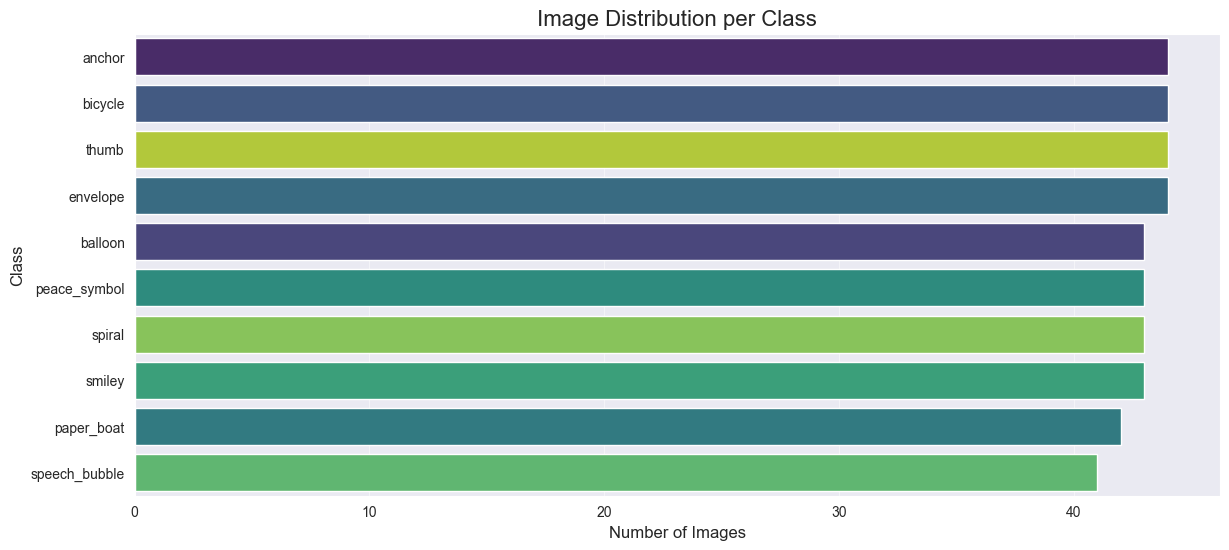

Largest class has: 44 samples
Smallest class has: 41 samples
Conclusion - Dataset is well balanced in terms of samples per class


In [43]:
plt.figure(figsize=(14, 6))
sns.countplot(y="class_name", data=data_df, order=data_df["class_name"].value_counts().index, palette="viridis", hue="class_name", legend=False)
plt.title("Image Distribution per Class", fontsize=16)
plt.xlabel("Number of Images", fontsize=12)
plt.ylabel("Class", fontsize=12)
plt.grid(axis="x", alpha=0.5)
plt.show()

# Check for class imbalance
class_counts = data_df["class_name"].value_counts()
min_count = class_counts.min()
max_count = class_counts.max()

print(f"Largest class has: {max_count} samples")
print(f"Smallest class has: {min_count} samples")

# Conclusion 1: Balance analysis

if max_count / min_count > 1.2:
    print(f"Potential issue -> Slight class imbalance detected (ratio: {max_count / min_count:.2f}). Weighted training may be required.")
else:
    print("Conclusion - Dataset is well balanced in terms of samples per class")


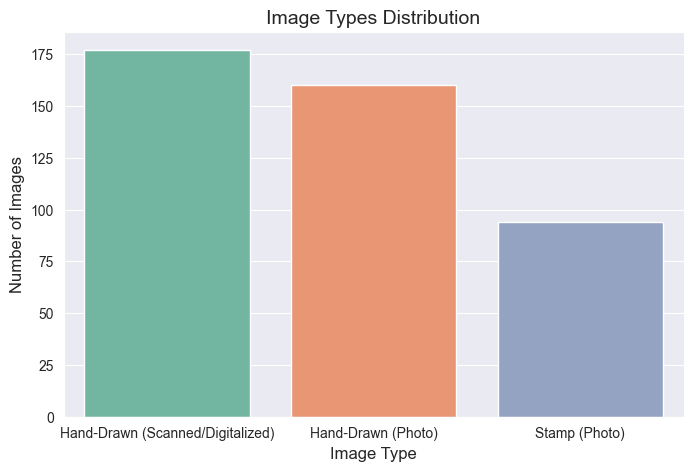

In [44]:
plt.figure(figsize=(8,5))
sns.countplot(x='image_type', data=data_df, palette="Set2", hue="image_type", legend=False)
plt.title("Image Types Distribution", fontsize=14)
plt.xlabel("Image Type", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.show()

In [45]:
# Analiza 100 losowych próbek pod kątem rozmiaru i trybu koloru
sample_files = data_df["filepath"].sample(min(200, len(data_df)), random_state=42)
sizes = []
modes = []

for f in sample_files:
    try:
        img = Image.open(f)
        sizes.append(img.size)
        modes.append(img.mode)
    except Exception as e:
        print(f"Error loading file {f}: {e}")

widths = [s[0] for s in sizes]
heights = [s[1] for s in sizes]

print("\nImage Size Statistics:")
print(f"Unique sizes: {set(sizes) if len(set(sizes)) < 10 else 'Many different sizes'}")
print(f"Median width: {np.median(widths)}, median height: {np.median(heights)}")

mode_counts = pd.Series(modes).value_counts()
print("\nColor Depth Statistics (PIL Mode):")
print(mode_counts)

if len(set(sizes)) > 1:
    print("\nEDA CONCLUSION: Image sizes are heterogeneous. Unification required (`Resize`) in Stage 2.")
else:
    print("\nOK")
if len(mode_counts) > 1:
    print("EDA CONCLUSION: Mixed color modes detected (e.g., RGB and Grayscale). Conversion to uniform format (e.g., RGB) required in Stage 2.")
else:
    print("\nOK")


Image Size Statistics:
Unique sizes: {(160, 130)}
Median width: 160.0, median height: 130.0

Color Depth Statistics (PIL Mode):
L    200
Name: count, dtype: int64

OK

OK


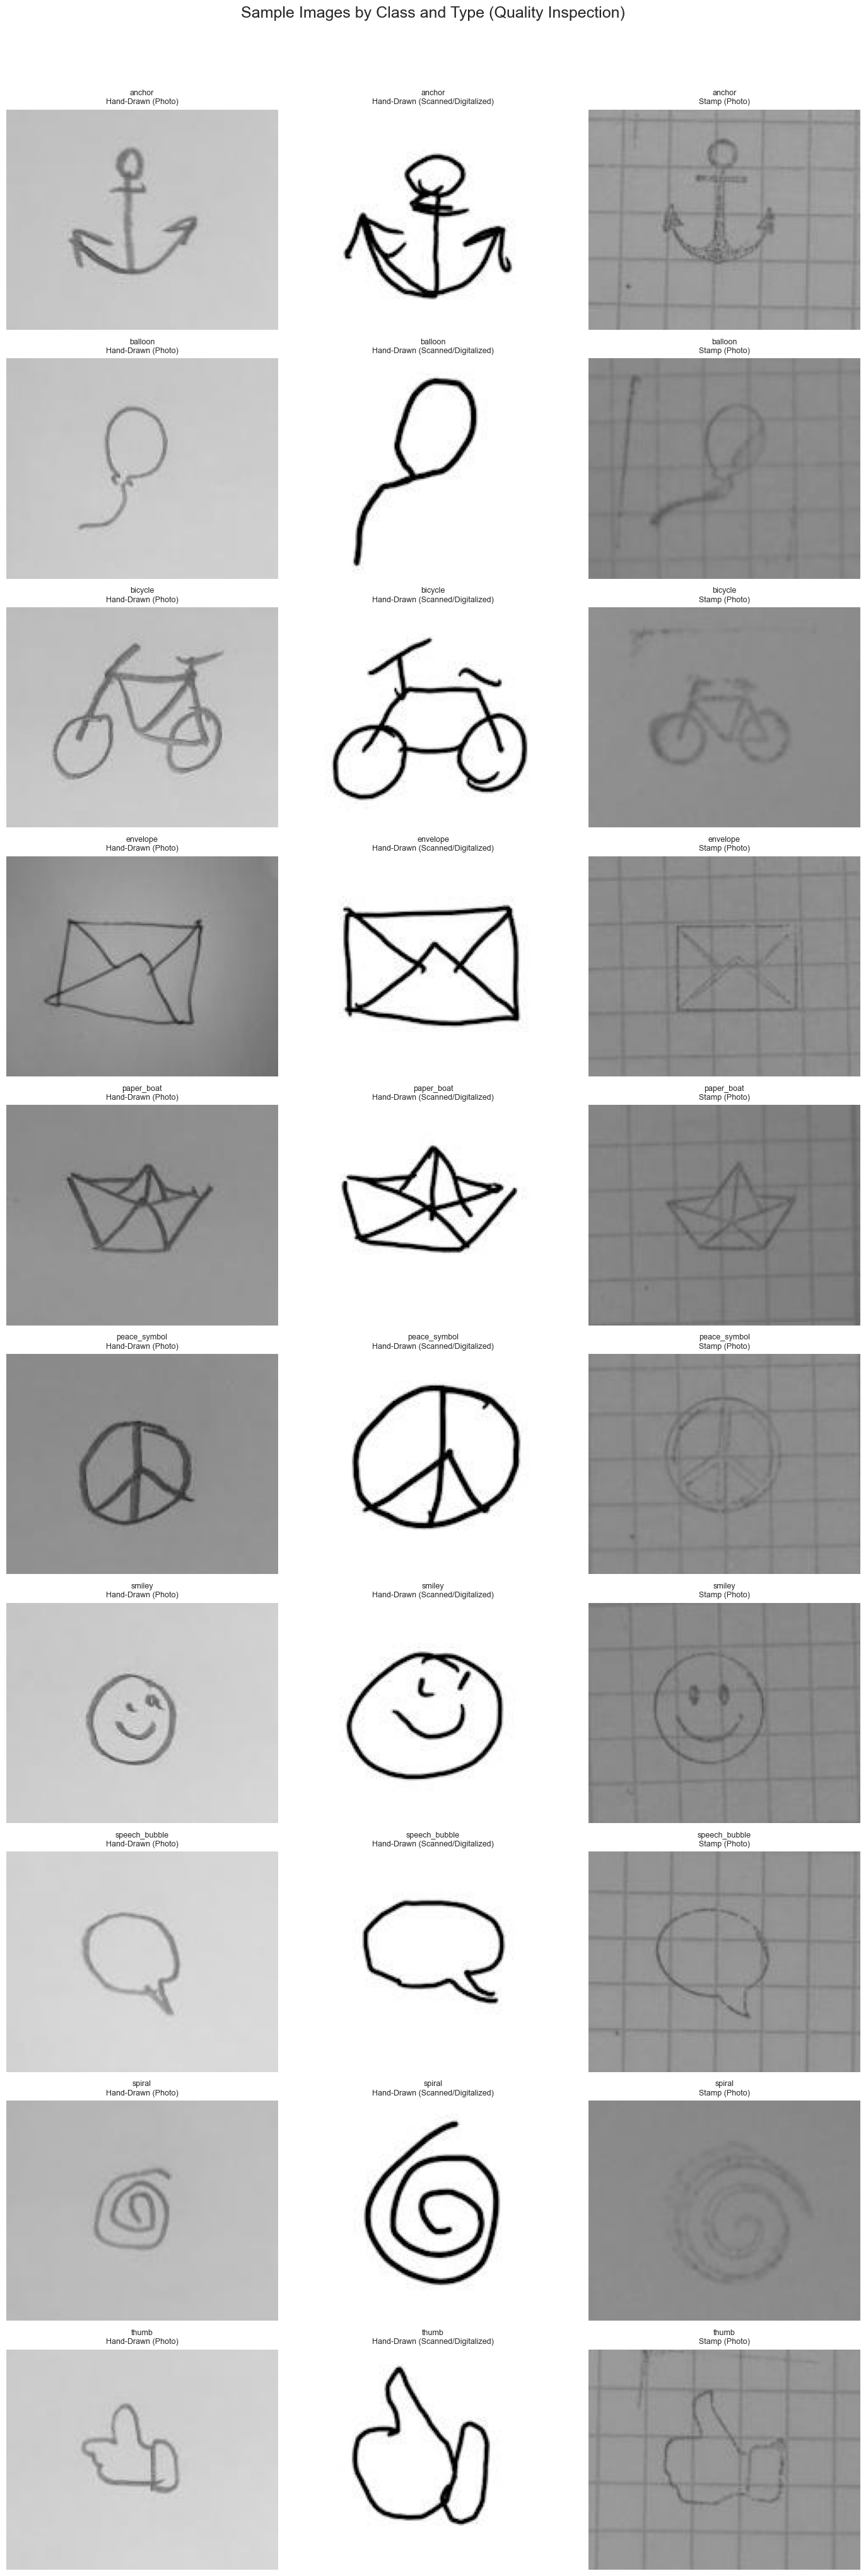

In [46]:
# Sample visualization
classes = data_df["class_name"].unique()
fig, axes = plt.subplots(len(classes), 3, figsize=(14, 4 * len(classes)))
plt.suptitle("Sample Images by Class and Type (Quality Inspection)", y=1.02, fontsize=18)

for i, class_name in enumerate(classes):
    class_data = data_df[data_df["class_name"] == class_name]

    for j, img_type in enumerate(["Hand-Drawn (Photo)", "Hand-Drawn (Scanned/Digitalized)", "Stamp (Photo)"]):
        sample = class_data[class_data["image_type"] == img_type].head(1)

        if not sample.empty:
            filepath = sample["filepath"].iloc[0]
            img = Image.open(filepath).convert("RGB")
            axes[i,j].imshow(img)
            axes[i,j].set_title(f"{class_name}\n{img_type}", fontsize=9)
        else:
            axes[i,j].set_title(f"No samples: {img_type}", fontsize=9)

        axes[i,j].axis("off")

plt.tight_layout()
plt.show()

In [47]:
# Using train_test_split with stratification to maintain class blance in subset
TEST_SIZE = 0.15 # 15% for the Test set
VAL_SIZE = 0.15  # 15% for the Validation set

# 1. Split off the test set (TEST)
train_val_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=42, stratify=data_df["class_name"])

# 2. Split remaining data into training (TRAIN) and validation (VAL) sets
# Calculate validation set proportion relative to the new smaller set (train_val_df)
val_relative_size = VAL_SIZE / (1 - TEST_SIZE)

train_df, val_df = train_test_split(train_val_df, test_size=val_relative_size, random_state=42, stratify=train_val_df["class_name"])

GLOBAL_CLASS_TO_IDX = {name: i for i, name in enumerate(train_df['class_name'].unique())}
GLOBAL_IDX_TO_CLASS = {i: name for name, i in GLOBAL_CLASS_TO_IDX.items()}

print("DATA SPLIT INTO SETS (STRATIFIED):")
print(f"Training Set (TRAIN): {len(train_df)} images")
print(f"Validation Set (VAL): {len(val_df)} images")
print(f"Test Set (TEST) LOCKED: {len(test_df)} images")

DATA SPLIT INTO SETS (STRATIFIED):
Training Set (TRAIN): 301 images
Validation Set (VAL): 65 images
Test Set (TEST) LOCKED: 65 images


In [48]:
import torch
from torchvision import transforms

IMAGE_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    # Conversion: From 1 channel (Grayscale/L) to 3 channels (RGB), duplicating the data..
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((256,256)),

    # Augmentation: increases data variability
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.3),
    transforms.ColorJitter(brightness=0.1, saturation=0.1),  # Delikatny jitter mimo że to Grayscale
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])


val_test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((256,256)),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

print("PyTorch Transforms defined. Grayscale to 3-channel conversion included.")

PyTorch Transforms defined. Grayscale to 3-channel conversion included.


In [49]:
from torch.utils.data import Dataset, DataLoader
NUM_CLASSES = len(GLOBAL_CLASS_TO_IDX)


class SimpleDrawingDataset(Dataset):
    def __init__(self, dataframe, transform=None, class_to_idx=None):
        self.dataframe = dataframe
        self.transform = transform
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        filepath = self.dataframe["filepath"].iloc[idx]
        class_name = self.dataframe["class_name"].iloc[idx]

        # Open image (PIL automatically handles 'L' mode)
        image = Image.open(filepath)

        # Apply defined transformations
        if self.transform:
            image = self.transform(image)

        # Convert class name to numerical index
        label = self.class_to_idx[class_name]

        return image, label

# Initalize Dataset objects
train_dataset = SimpleDrawingDataset(train_df, train_transform, GLOBAL_CLASS_TO_IDX)
val_dataset = SimpleDrawingDataset(val_df, val_test_transforms, GLOBAL_CLASS_TO_IDX)
test_dataset = SimpleDrawingDataset(test_df, val_test_transforms, GLOBAL_CLASS_TO_IDX)

BATCH_SIZE = 32
#num_workers = os.cpu_count() // 2 or 1
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=num_workers, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=num_workers, shuffle=False)

print(f"Number of Classes: {NUM_CLASSES}")
print(f"Number of batches in training set: {len(train_loader)}")
print("Dataset and DataLoader objects are ready. Data is 3x224x224 and normalized.")





Number of Classes: 10
Number of batches in training set: 10
Dataset and DataLoader objects are ready. Data is 3x224x224 and normalized.


Verifying Preprocessing and Augmentation:


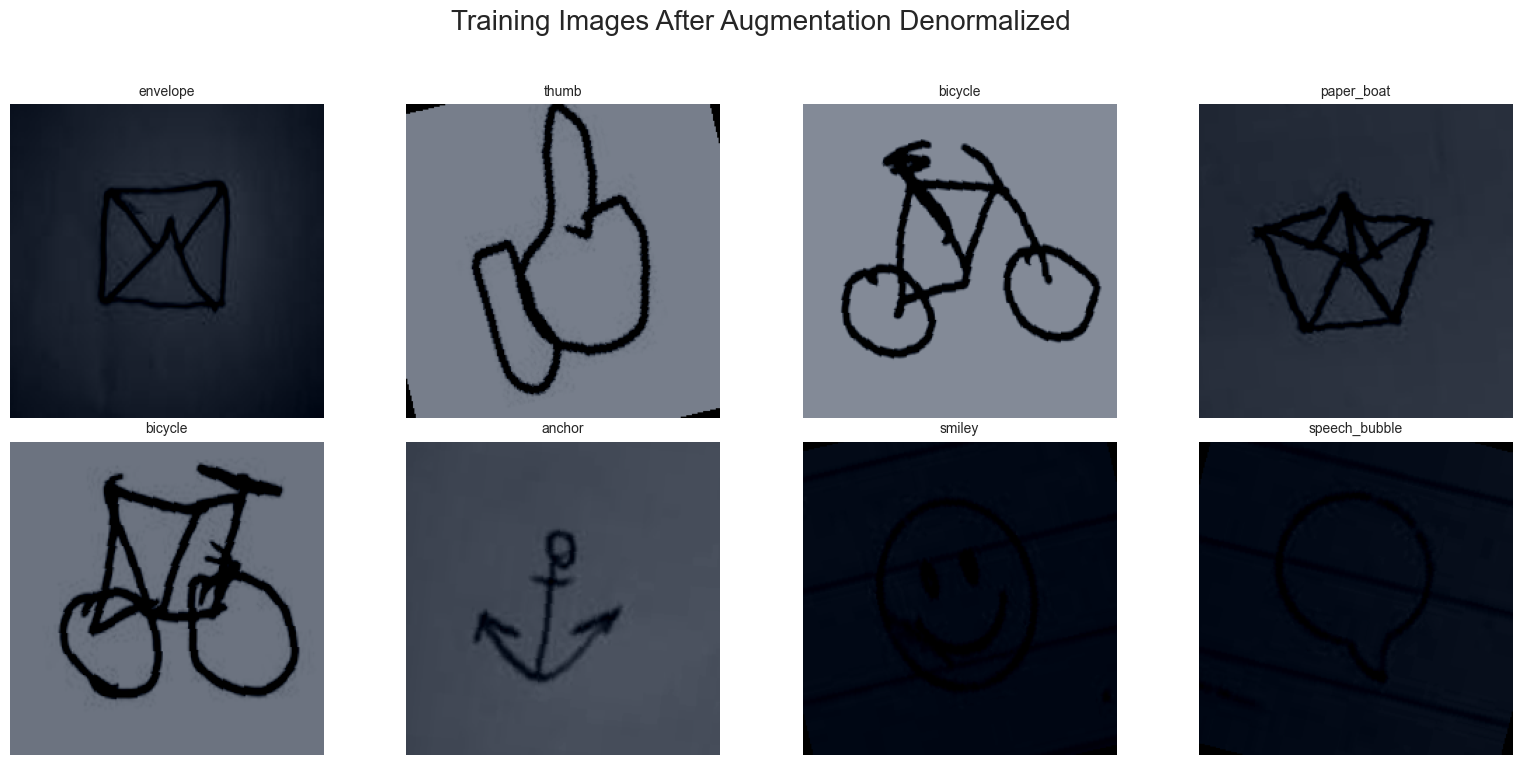


Tensor shape after preprocessing (Batch, Channels, Height, Width): torch.Size([32, 3, 224, 224])


In [50]:
# Helper function for denormalization (reverses normalization for visualization)
def denormalize(tensor):
    img_array = tensor.cpu().detach().numpy().transpose((1, 2, 0))
    mean = np.array(IMAGENET_MEAN)
    std = np.array(IMAGENET_STD)
    img_array *= std

    return np.clip(img_array, 0, 1)

print("Verifying Preprocessing and Augmentation:")

images, labels = next(iter(train_loader))
plt.figure(figsize=(16, 8))

for i in range(8):
    if i >= images.shape[0]:
        break

    ax = plt.subplot(2, 4, i + 1)

    image_denorm = denormalize(images[i])

    # Ponieważ konwertowaliśmy Grayscale na RGB, wyświetlamy normalnie

    plt.imshow(image_denorm)
    plt.title(GLOBAL_IDX_TO_CLASS[labels[i].item()], fontsize=10)
    plt.axis('off')

plt.suptitle("Training Images After Augmentation Denormalized", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Tensor shape check (sprawdzenie kształtu)
print(f"\nTensor shape after preprocessing (Batch, Channels, Height, Width): {images.shape}")

In [51]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Checking GPU availability (CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [52]:
# print(f"CUDA Available: {torch.cuda.is_available()}")
#
# if torch.cuda.is_available():
#     print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")
#     print(f"Device Count: {torch.cuda.device_count()}")
# else:
#     print("CUDA is NOT available")

In [53]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(weights='IMAGENET1K_V1')

# Set require_grad=False to train only at the latest, which is standard in Transfer Learning
for param in model.parameters():
    param.requires_grad = False

# Get the number of features from the last layer (fully connected layer - fc)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

# Move the entire model to the selected device (CPU/GPU)
model = model.to(device)

print(NUM_CLASSES)
print("ResNet-18 model loaded, base layers frozen, and classification head adapted.")
print(f"New output layer size: {model.fc.out_features}")


10
ResNet-18 model loaded, base layers frozen, and classification head adapted.
New output layer size: 10


In [54]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 20 # we can experiment with this number
LOG_INTERVAL = 50

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.fc.parameters(), lr=LEARNING_RATE)

print("Loss function and Optimizer defined")

Loss function and Optimizer defined


In [55]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=NUM_EPOCHS):
    best_acc = 0.0

    history = {'train_loss' : [], 'val_loss' : [], "val_acc" : []}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # --- Training Phase ---
        model.train() # We set model to train
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_loss)
        print(f"Training Loss: {epoch_loss}")

        # --- Validation Phase ---
        model.eval() # Ustawienie modelu w tryb ewaluacji (wyłącza dropout, itp.)
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad(): #Turn off gradient
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        val_loss = running_loss / len(val_loader.dataset)
        val_acc = running_corrects.double() / len(val_loader.dataset)

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())

        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        # Save the best model weights
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model_weights.pth")
            print("Saved best model")

    print(f'\nTraining complete. Best Val Acc: {best_acc:.4f}')
    return model, history

final_model, history = train_model(model, criterion, optimizer, train_loader, val_loader)

print("\nModel training finished and the best weights saved to 'best_model_weights.pth'.")



Epoch 1/20
----------
Training Loss: 2.3205281420799584
Val Loss: 2.1861 Acc: 0.2154
Saved best model
Epoch 2/20
----------
Training Loss: 1.989006213175498
Val Loss: 2.0236 Acc: 0.3385
Saved best model
Epoch 3/20
----------
Training Loss: 1.6912431693156296
Val Loss: 1.8712 Acc: 0.3692
Saved best model
Epoch 4/20
----------
Training Loss: 1.4517153469827089
Val Loss: 1.6756 Acc: 0.5692
Saved best model
Epoch 5/20
----------
Training Loss: 1.2231987144463878
Val Loss: 1.5002 Acc: 0.5385
Epoch 6/20
----------
Training Loss: 1.1315230289566953
Val Loss: 1.2747 Acc: 0.8000
Saved best model
Epoch 7/20
----------
Training Loss: 0.9711477602043025
Val Loss: 1.1001 Acc: 0.8154
Saved best model
Epoch 8/20
----------
Training Loss: 0.9571176589129375
Val Loss: 0.9643 Acc: 0.8923
Saved best model
Epoch 9/20
----------
Training Loss: 0.8602653741836548
Val Loss: 0.8981 Acc: 0.9077
Saved best model
Epoch 10/20
----------
Training Loss: 0.8005563359323926
Val Loss: 0.7996 Acc: 0.9077
Epoch 11/20
--

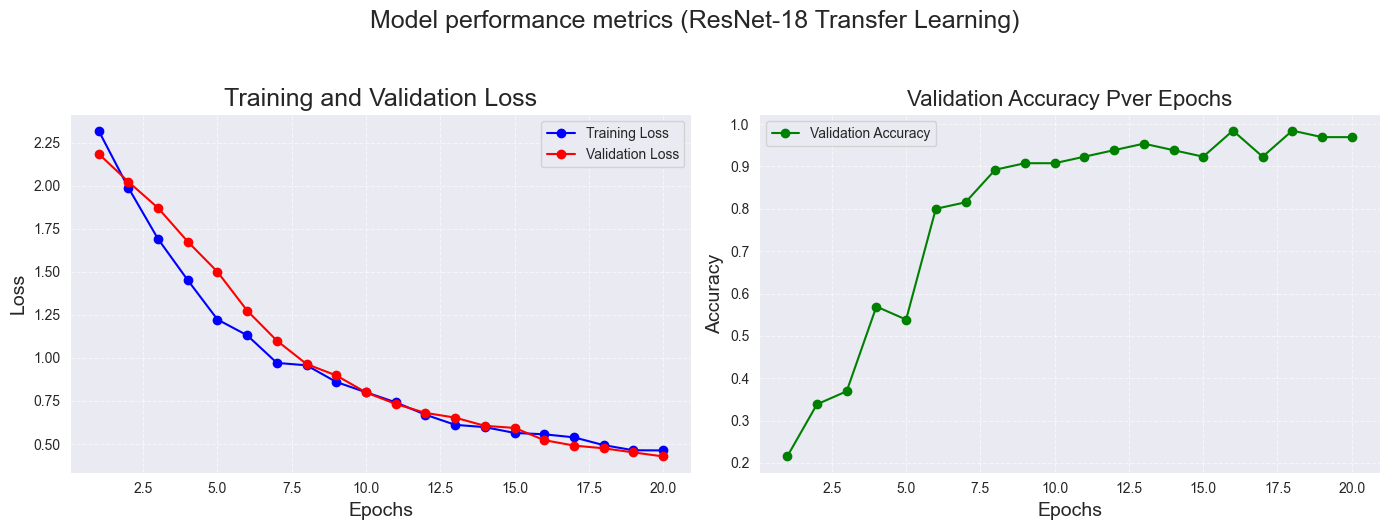

In [56]:
train_loss = history["train_loss"]
val_loss = history["val_loss"]
val_acc = history["val_acc"]
epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(14, 5))

#Chart 1: Loss

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, "bo-", label="Training Loss")
plt.plot(epochs, val_loss, "ro-", label="Validation Loss")
plt.title("Training and Validation Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

#Chart 2: Accuracy
plt.subplot(1, 2, 2)

# Validation accuracy is usually stored as a tensor or a NumPy array, so we’ll use .item().
val_acc_items = [acc_tensor.item() if isinstance(acc_tensor, torch.Tensor) else acc_tensor for acc_tensor in val_acc]
plt.plot(epochs, val_acc_items, "go-", label="Validation Accuracy")
plt.title("Validation Accuracy Pver Epochs", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.suptitle('Model performance metrics (ResNet-18 Transfer Learning)', fontsize=18, y=1.05)
plt.tight_layout()
plt.show()

Starting evaluation on the LOCKED test set...

FINAL CLASSIFICATION REPORT ON TEST SET (SET BLOCKED)
               precision    recall  f1-score   support

     envelope     0.8750    1.0000    0.9333         7
      balloon     1.0000    0.8333    0.9091         6
      bicycle     1.0000    1.0000    1.0000         7
 peace_symbol     0.8571    1.0000    0.9231         6
       smiley     1.0000    0.7143    0.8333         7
        thumb     1.0000    0.8571    0.9231         7
       anchor     1.0000    1.0000    1.0000         7
       spiral     0.8571    1.0000    0.9231         6
   paper_boat     1.0000    1.0000    1.0000         6
speech_bubble     0.8571    1.0000    0.9231         6

     accuracy                         0.9385        65
    macro avg     0.9446    0.9405    0.9368        65
 weighted avg     0.9470    0.9385    0.9369        65



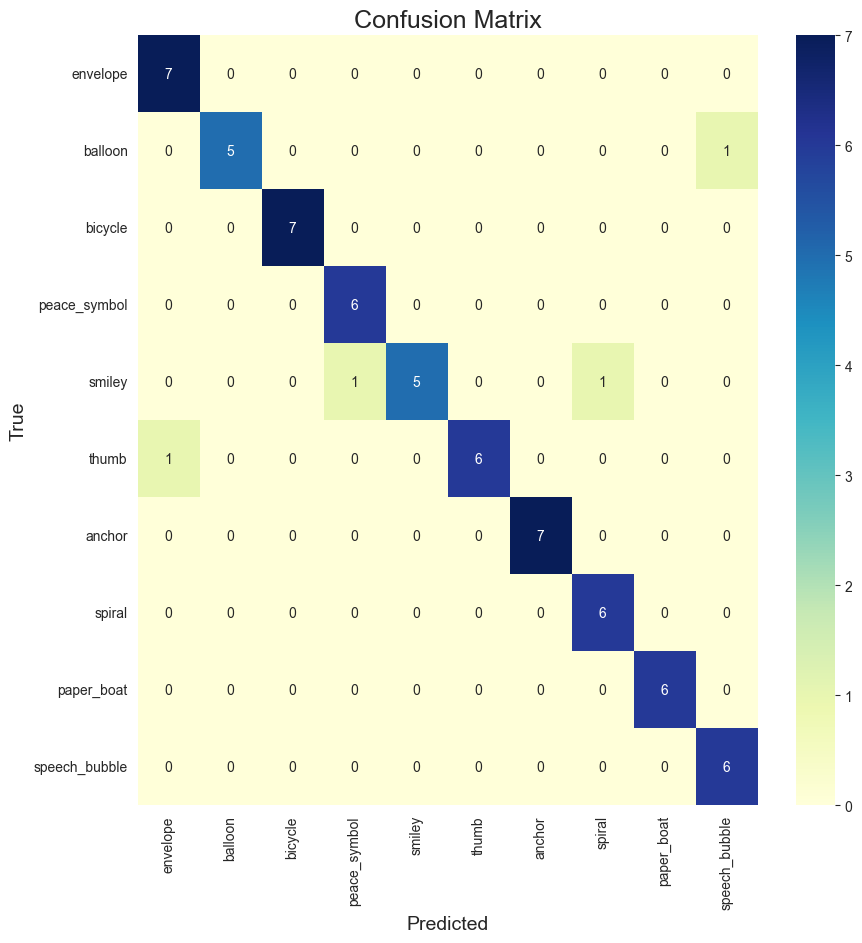

In [57]:
from sklearn.metrics import classification_report, confusion_matrix

model = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
model = model.to(device)

# Load the best weight
model.load_state_dict(torch.load("best_model_weights.pth",  map_location=device))
model.eval() # Set the model to evaluation mode

y_true = []
y_pred = []

print("Starting evaluation on the LOCKED test set...")

# 2. Carrying out the prediction
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# 3. Converting indexes to class names for the report


target_name = [GLOBAL_IDX_TO_CLASS[i] for i in range(NUM_CLASSES)]

# 4. View the classification report
print("\n" + "="*70)
print("FINAL CLASSIFICATION REPORT ON TEST SET (SET BLOCKED)")
print("="*70)
print(classification_report(y_true, y_pred, target_names=target_name, digits=4))
print("="*70)

# 5. Confusion Matrix Display
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=target_name, yticklabels=target_name)
plt.title("Confusion Matrix", fontsize=18)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.show()

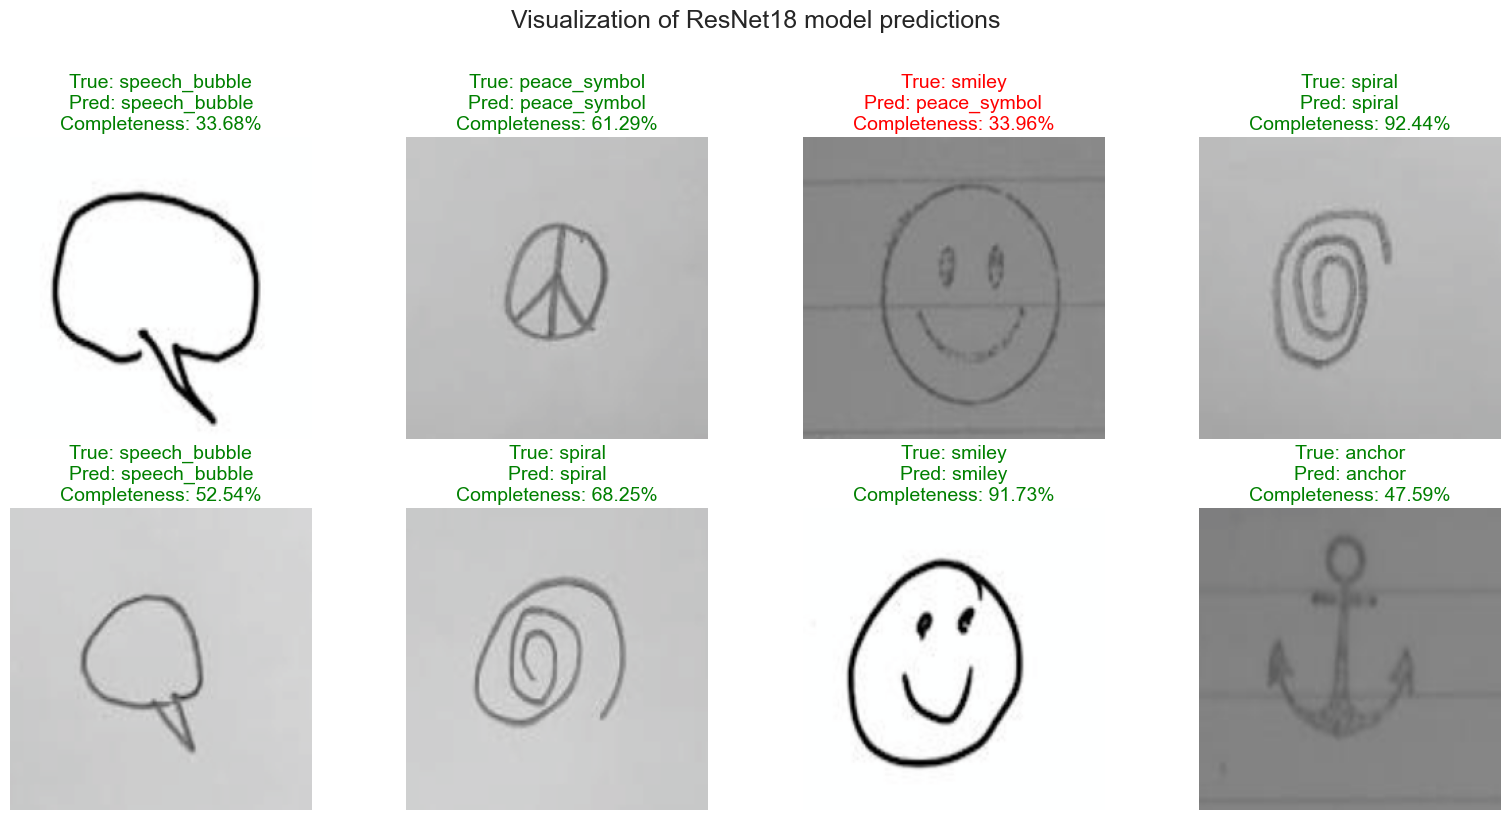

In [58]:
import torch.nn.functional as F

# Let's make sure the best weights are loaded and the model is in evaluation mode.
model.load_state_dict(torch.load("best_model_weights.pth", map_location=device))
model.eval()


def denormalize_image(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Tensor -> Numpy
    img_array = tensor.cpu().numpy().transpose((1, 2, 0)) # C, H, W -> H, W, C

    # Denormalization
    img_array = std * img_array + mean

    # Clipping values to the [0,1] range
    return np.clip(img_array, 0, 1)

def visualize_predictions(model, test_loader, num_samples=8):
    # We extract one batch of text data.

    data_iter = iter(test_loader)
    images, labels = next(data_iter)

    # We limit ourselves to the desired number of samples.
    images = images[:num_samples]
    labels = labels[:num_samples]

    images = images.to(device)

    # Making a prediction
    with torch.no_grad():
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1) # Converting logits to probabilities

    # Obtaining the best prediction and its probability
    confidences, predictions = torch.max(probabilities, 1)

    # Drawing
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    for i in range(num_samples):
        # Denormalizing the image for display
        image_denorm = denormalize_image(images[i])

        # Fetching labels
        true_class_idx = labels[i].item()
        pred_class_idx = predictions[i].item()
        confidence = confidences[i].item() * 100 # Confidence percentage

        true_label = GLOBAL_IDX_TO_CLASS[true_class_idx]
        pred_label = GLOBAL_IDX_TO_CLASS[pred_class_idx]

        is_correct = (true_class_idx == pred_class_idx)

        # Displaying the image
        axes[i].imshow(image_denorm)
        axes[i].axis("off")
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}\nCompleteness: {confidence:.2f}%", color=("green" if is_correct else "red"), fontsize=14)

    plt.suptitle("Visualization of ResNet18 model predictions", fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader, num_samples=8)



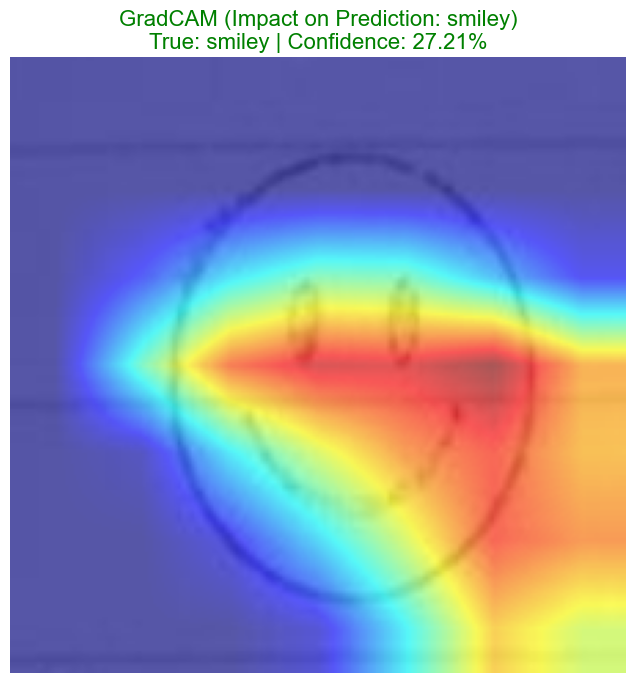

In [22]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Reloading the model and setting it to evaluation mode
model = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
model.load_state_dict(torch.load('best_model_weights.pth', map_location=device))
model.eval()
model = model.to(device)

# Definition of the Last Convolutional Layer (Target Layer)
target_layers = [model.layer4[-1]]

# Helper function to obtain the processed tensor and the raw image for visualization
def get_sample_for_cam(loader, index):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    # We select the image with a specified index
    input_tensor = images[index].unsqueeze(0).to(device)
    true_label_idx = labels[index].item()

    # Processing the tensor into a raw NumPy image for the show_cam_on_image function (denormalization)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    rgb_img = input_tensor.cpu().squeeze(0).numpy().transpose(1, 2, 0)
    rgb_img = std * rgb_img + mean
    rgb_img = np.clip(rgb_img, 0, 1)

    return input_tensor, rgb_img, true_label_idx

# Sample selection
SAMPLE_INDEX = 2
input_tensor, rgb_img, true_label_idx = get_sample_for_cam(test_loader, index=SAMPLE_INDEX)

# Making a Prediction
with torch.no_grad():
    outputs = model(input_tensor)
    probabilities = F.softmax(outputs, dim=1)
    confidences, predicted_idx = torch.max(probabilities, 1)

predicted_label = GLOBAL_IDX_TO_CLASS[predicted_idx.item()]
true_label = GLOBAL_IDX_TO_CLASS[true_label_idx]
confidence = confidences.item() * 100

# Definition of the Target for GradCAM
targets = [ClassifierOutputTarget(predicted_idx.item())]

# Initialization and Execution of GradCAM
cam = GradCAM(model=model, target_layers=target_layers)
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :] # Usunięcie wymiaru batcha

# Overlaying the Heatmap
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# Visualization
is_correct = (predicted_idx.item() == true_label_idx)
color = 'green' if is_correct else 'red'

plt.figure(figsize=(8, 8))
plt.imshow(cam_image)
plt.title(f"GradCAM (Impact on Prediction: {predicted_label})\nTrue: {true_label} | Confidence: {confidence:.2f}%",
          fontsize=16, color=color)
plt.axis('off')
plt.show()